<a href="https://colab.research.google.com/github/fagonzalezo/qmc/blob/master/examples/Mixture_of_patches_classification_with_QMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixture of patches classification with QMC

Contains code from [Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

In [2]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install --upgrade  git+https://github.com/fagonzalezo/qmc.git
    !pip install -U tensorflow-addons
else:
    import sys
    sys.path.insert(0, "../")



  Cloning https://github.com/fagonzalezo/qmc.git to /tmp/pip-req-build-pygruv4d
  Running command git clone -q https://github.com/fagonzalezo/qmc.git /tmp/pip-req-build-pygruv4d
  Created wheel for qmc: filename=qmc-0.0.1-py3-none-any.whl size=12756 sha256=2be602c94cfe1a94d3e287c4fc1a6fc852e3e5b76ac7c5c4b160c1ce99427781
  Stored in directory: /tmp/pip-ephem-wheel-cache-od7_b_fz/wheels/b2/d2/8d/5870208920445c46dfe694f549251e5f63d7afbee56c01f720
Successfully built qmc
     |████████████████████████████████| 1.1 MB 8.2 MB/s 


## Setup

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import qmc.tf.layers as layers
import qmc.tf.models as models

## Prepare the data

Load the MNIST data set. Use one-hot encoding so that we can use label smoothing during training.

In [4]:
import sklearn

num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

ohe = sklearn.preprocessing.OneHotEncoder(sparse=False)
y_train = ohe.fit_transform(y_train.reshape((-1,1)))
y_test = ohe.transform(y_test.reshape((-1,1)))
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


11501568/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1) - y_train shape: (60000, 10)
x_test shape: (10000, 28, 28, 1) - y_test shape: (10000, 10)


## Configure the hyperparameters

In [105]:
# learning_rate = 0.001
# weight_decay = 0.0001
# batch_size = 256
# num_epochs = 10
image_size = 28  
patch_size = 7  # Size of the patches to be extracted from the input images
num_patches = (image_size // patch_size) ** 2
# projection_dim = 64
# input_dim = 64
# num_rff = 512
# gamma = 2**-5
# n_comp = 80
# random_state = 0

# mlp_head_units = [256]  # Size of the dense layers of the final classifier


## Use data augmentation

For the MNIST dataset we don't really do aumentation, but it could be helpful for other datasets.

In [106]:
data_augmentation = keras.Sequential(
    [
        keras.layers.Normalization(),
        #layers.Resizing(image_size, image_size),
        #layers.RandomFlip("horizontal"),
        #keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        #keras.layers.RandomRotation(factor=0.02),
        #layers.RandomZoom(
        #    height_factor=0.2, width_factor=0.2
        #),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [107]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [108]:

class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, num_patches, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 28 X 28
Patch size: 7 X 7
Patches per image: 16
Elements per patch: 49


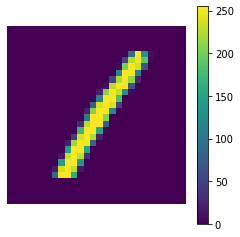

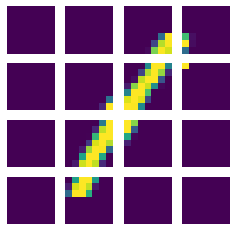

In [136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.reshape([image_size, image_size]))
plt.colorbar()
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8").reshape([patch_size, patch_size]))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector. `PatchEncoderFix` uses a fix positional embedding based on $\sin$ and $\cos$ with different frequencies. `PatchEncoderNone` doesn't have a positional encoder.

In [110]:
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

class PatchEncoderFix(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoderFix, self).__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        positional_embeddings = np.zeros((num_patches, projection_dim))
        for position in range(num_patches):
            for i in range(0, projection_dim, 2):
              positional_embeddings[position, i] = (
                  np.sin(position / (10000 ** ((2*i) / projection_dim)))
                                                    )
              positional_embeddings[position, i + 1] = (
                  np.cos(position / (10000 ** ((2 * (i + 1) ) / projection_dim)))
                                                        )
        self.position_embedding = tf.Variable(initial_value=positional_embeddings,
                                      dtype=tf.float32, 
                                      trainable=False)


    def call(self, patch):
        encoded = self.projection(patch) + self.position_embedding
        return encoded

class PatchEncoderNone(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoderNone, self).__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)

    def call(self, patch):
        encoded = self.projection(patch)
        return encoded

## Experiment script


In [114]:

def run_experiment(model, 
                   learning_rate=0.001, 
                   weight_decay=0.0001, 
                   label_smoothing=0,
                   epochs=10, 
                   batch_size=256
                   ):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
        ],
    )
    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history



# ViT + QMC 

This model applies transformer layers to the encoded patches before QMC. The number of transformer layers may be equal to zero.

In [211]:
def create_encoder(projection_dim=64, 
            transformer_layers=1, 
            num_heads=4):
    transformer_units = [
    projection_dim * 2,
    projection_dim,
    ]
    inputs = keras.layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    model = keras.Model(inputs=inputs, outputs=representation)
    return model

def create_ViT_QMC_model(projection_dim=64, 
                         transformer_layers=1, 
                         num_heads=4, 
                         gamma=2**-5,
                         n_comp=40,  
                         num_rff=512):
    inputs = keras.layers.Input(shape=input_shape)
    encoder = create_encoder(projection_dim=projection_dim, 
                             transformer_layers=transformer_layers, 
                             num_heads=num_heads)
    encoded_patches = encoder(inputs)
    fm_x1 = layers.QFeatureMapRFF(projection_dim, dim=num_rff , gamma=gamma)
    psi_x = tf.transpose(fm_x1(encoded_patches), perm=[0, 2, 1])
    ones = tf.ones_like(psi_x[:, 0:1, :], dtype=tf.float32) / num_patches
    rho_x = tf.keras.layers.concatenate((ones, psi_x), axis=1)
    qmdmc = layers.QMClassifSDecompFDMatrix(dim_x=num_rff, dim_y=10, n_comp=n_comp)
    rho_y = qmdmc(rho_x)
    y_w = rho_y[:, 0, :] # shape (b, d_in)
    y_v = rho_y[:, 1:, :] # shape (b, dim_x, d_in)
    probs = tf.einsum('...j,...ij,...ij->...i', y_w, y_v, tf.math.conj(y_v))
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=probs)
    return model

# QMC model without transformer layers

In [230]:
sigma = 7.
gamma = 1 / (2 * sigma ** 2)
QMC_model = create_ViT_QMC_model(transformer_layers=0, gamma=gamma, n_comp=40, num_rff=512)
QMC_model.summary()

Model: "model_76"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_78 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_75 (Functional)          (None, 16, 64)       4355        ['input_78[0][0]']               
                                                                                                  
 q_feature_map_rff_46 (QFeature  (None, 16, 512)     33280       ['model_75[0][0]']               
 MapRFF)                                                                                          
                                                                                                  
 tf.compat.v1.transpose_46 (TFO  (None, 512, 16)     0           ['q_feature_map_rff_46[0][

In [231]:
history = run_experiment(QMC_model, learning_rate=0.01, epochs=15)

Epoch 1/15
211/211 [==============================] - 4s 11ms/step - loss: 1.4152 - accuracy: 0.7402 - val_loss: 1.1288 - val_accuracy: 0.8907
Epoch 2/15
211/211 [==============================] - 2s 10ms/step - loss: 1.1424 - accuracy: 0.8676 - val_loss: 1.0880 - val_accuracy: 0.8963
Epoch 3/15
211/211 [==============================] - 2s 9ms/step - loss: 1.1151 - accuracy: 0.8749 - val_loss: 1.0716 - val_accuracy: 0.8988
Epoch 4/15
211/211 [==============================] - 2s 9ms/step - loss: 1.1016 - accuracy: 0.8800 - val_loss: 1.0685 - val_accuracy: 0.8915
Epoch 5/15
211/211 [==============================] - 2s 9ms/step - loss: 1.0933 - accuracy: 0.8803 - val_loss: 1.0542 - val_accuracy: 0.9040
Epoch 6/15
211/211 [==============================] - 2s 9ms/step - loss: 1.0868 - accuracy: 0.8834 - val_loss: 1.0579 - val_accuracy: 0.9007
Epoch 7/15
211/211 [==============================] - 2s 10ms/step - loss: 1.0817 - accuracy: 0.8844 - val_loss: 1.0469 - val_accuracy: 0.9047
Epo

We can check the weights of the QMC layer to see how many components have weights greater than zero.

Non-zero components:11


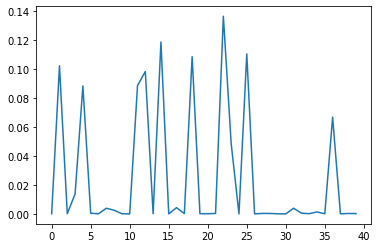

In [235]:
print(QMC_model.layers[8])
lamb = np.abs(QMC_model.layers[8].weights[2].numpy())
lamb = lamb / lamb.sum()
plt.plot(lamb)
num_comps = (lamb >= 0.01).sum()
print(f'Non-zero components:{num_comps}')

Now we train the model using label smoothing.

In [236]:
QMC_model = create_ViT_QMC_model(transformer_layers=0, gamma=gamma, n_comp=40, num_rff=512)
history = run_experiment(QMC_model, learning_rate=0.01, epochs=15, label_smoothing=0.4)

Epoch 1/15
211/211 [==============================] - 4s 11ms/step - loss: 1.8596 - accuracy: 0.7712 - val_loss: 1.7168 - val_accuracy: 0.9192
Epoch 2/15
211/211 [==============================] - 2s 10ms/step - loss: 1.7257 - accuracy: 0.9028 - val_loss: 1.7031 - val_accuracy: 0.9233
Epoch 3/15
211/211 [==============================] - 2s 10ms/step - loss: 1.7139 - accuracy: 0.9116 - val_loss: 1.6942 - val_accuracy: 0.9320
Epoch 4/15
211/211 [==============================] - 2s 9ms/step - loss: 1.7077 - accuracy: 0.9151 - val_loss: 1.6911 - val_accuracy: 0.9287
Epoch 5/15
211/211 [==============================] - 2s 9ms/step - loss: 1.7031 - accuracy: 0.9171 - val_loss: 1.6885 - val_accuracy: 0.9317
Epoch 6/15
211/211 [==============================] - 2s 9ms/step - loss: 1.7005 - accuracy: 0.9184 - val_loss: 1.6854 - val_accuracy: 0.9300
Epoch 7/15
211/211 [==============================] - 2s 9ms/step - loss: 1.6982 - accuracy: 0.9206 - val_loss: 1.6891 - val_accuracy: 0.9293
Epo

Non-zero components:10


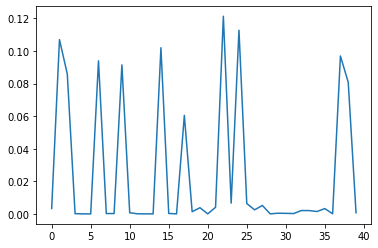

In [239]:
print(QMC_model.layers[8])
lamb = np.abs(QMC_model.layers[8].weights[2].numpy())
lamb = lamb / lamb.sum()
plt.plot(lamb)
num_comps = (lamb >= 0.01).sum()
print(f'Non-zero components:{num_comps}')

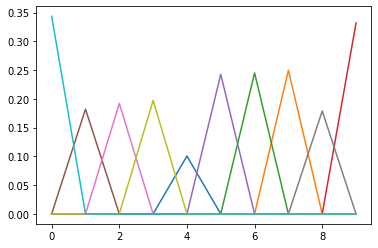

In [240]:
for i in range(len(lamb)):
  if lamb[i] >= 0.01:
    vals = QMC_model.layers[8].weights[1][:,i] 
    plt.plot(QMC_model.layers[8].weights[1][:,i]**2)

# Visualization of patch probabilities

Since the model assigns a probability to each patch, we can visualize it for different labels to understand how the model classifies. Each possible label is propagated back to get a patch density matrix associated to the corresponding label. The patches of an image are propagated forward an the probability of each patch is calculated for each label density matrix.

In [241]:
def attention_model(ViT_QMC_model, img_in, y_in):
  # ViT_QMC_model layers
  encoder = ViT_QMC_model.layers[1]
  qmcdm_layer = ViT_QMC_model.layers[8]
  rff_layer = ViT_QMC_model.layers[2]
  projection_dim = rff_layer.input_dim
  num_rff = rff_layer.dim
  n_comp = qmcdm_layer.n_comp

  # encode input image
  encoded_patches = encoder(img_in)
  psi_x = tf.transpose(rff_layer(encoded_patches), perm=[0, 2, 1])

  # Propagate back label
  inv_qmcdm = QMClassifSDecompFDMatrix(dim_x=y_in.shape[1], dim_y=num_rff, n_comp=n_comp)
  ones = tf.ones_like(y_in[:, 0:1])
  rho_y = tf.keras.layers.concatenate((ones, y_in), axis=1)
  rho_y = tf.expand_dims(rho_y, axis=-1)
  inv_qmcdm(rho_y)
  qmcdm_weights = qmcdm_layer.weights
  inv_qmcdm.set_weights([qmcdm_weights[1], qmcdm_weights[0], qmcdm_weights[2]])
  rho_x = inv_qmcdm(rho_y)
  x_w = rho_x[:, 0, :] # shape (b, n_comp)
  x_v = rho_x[:, 1:, :] # shape (b, num_rff, n_comp)

  # Calculate patch probabilities
  projs = tf.einsum('...j,...ij,...ik->...jk', tf.sqrt(x_w), x_v, psi_x, 
                    optimize='optimal')
  probs = tf.einsum('...jk,...jk->...k', tf.math.conj(projs), projs)
  return probs


In [242]:
def image_show(img_idx):
  plt.figure(figsize=(4, 4))
  image = x_test[img_idx]
  plt.imshow(image.reshape([image_size, image_size]))
  plt.colorbar()
  plt.axis("off")

image_basis = np.zeros([num_patches, image_size, image_size])
patch_idx = 0
for i in range(int(np.sqrt(num_patches))):
  for j in range(int(np.sqrt(num_patches))):
    image_basis[patch_idx,
                i * patch_size:(i + 1) * patch_size, 
                j * patch_size:(j + 1) * patch_size] = 1.
    patch_idx += 1

def attention_show(attention):
  plt.figure(figsize=(12, 12))
  vmin = np.min(attention)
  vmax = np.max(attention)
  for i in range(attention.shape[0]):
    att_image = np.einsum('i,ijk->jk', attention[i], image_basis)
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(att_image, vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.title(f'y = {i}')

prediction:[[0.03131264 0.10620154 0.03549382 0.05535785 0.30869964 0.06498612
  0.04634749 0.11415983 0.09874503 0.13869607]]


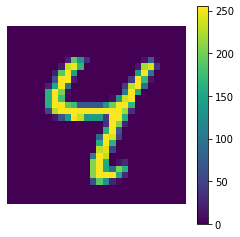

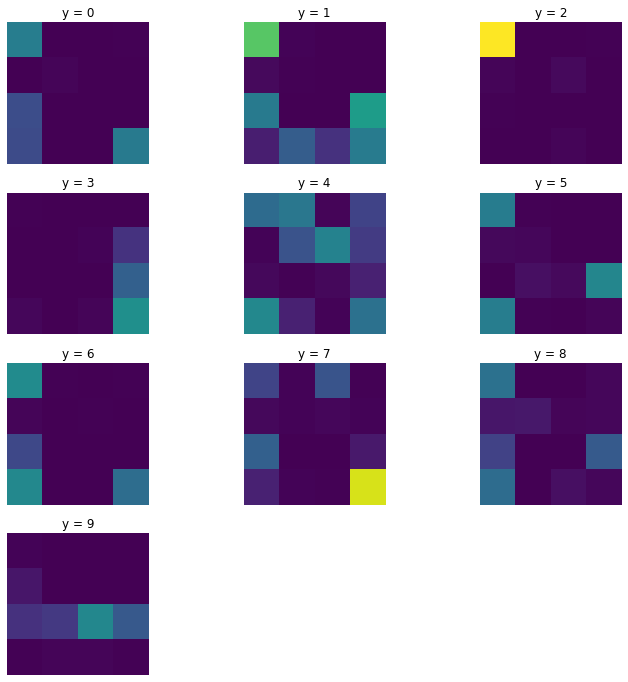

In [244]:
img_idx = 6
image_show(img_idx)
img_in = np.tile(x_test[img_idx], [10,1,1,1])
y_in = np.eye(10)
attention = attention_model(QMC_model, img_in, y_in)
attention_show(attention)
print(f'prediction:{QMC_model(x_test[img_idx:img_idx+1])}')

prediction:[[0.06742192 0.06198527 0.15887438 0.04968583 0.10351417 0.05682071
  0.04729769 0.10641143 0.0945364  0.25345224]]


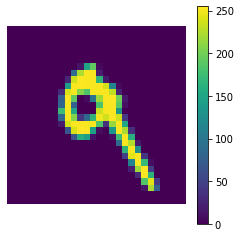

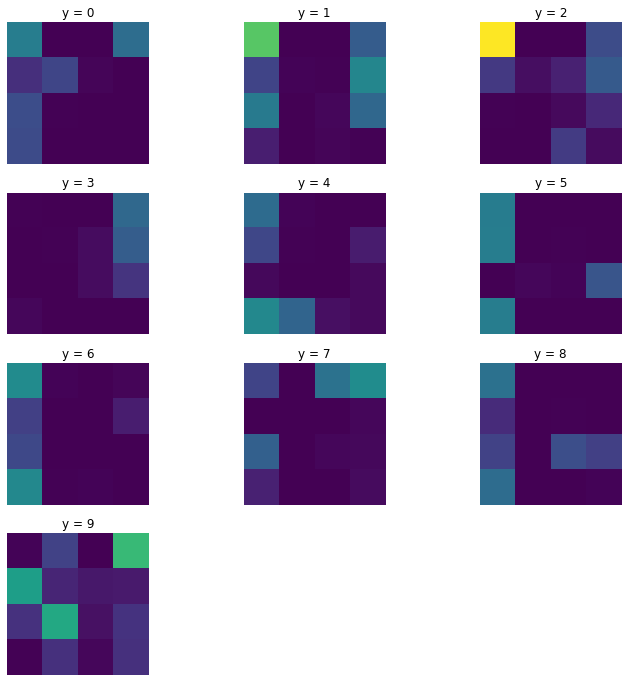

In [246]:
img_idx = 7
image_show(img_idx)
img_in = np.tile(x_test[img_idx], [10,1,1,1])
y_in = np.eye(10)
attention = attention_model(QMC_model, img_in, y_in)
attention_show(attention)
print(f'prediction:{QMC_model(x_test[img_idx:img_idx+1])}')

# ViT + QMC model

In [247]:
sigma = 7.
gamma = 1 / (2 * sigma ** 2)
QMC_model = create_ViT_QMC_model(transformer_layers=1, gamma=gamma, n_comp=40, num_rff=512)
QMC_model.summary()

Model: "model_80"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_82 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_79 (Functional)          (None, 16, 64)       87555       ['input_82[0][0]']               
                                                                                                  
 q_feature_map_rff_48 (QFeature  (None, 16, 512)     33280       ['model_79[0][0]']               
 MapRFF)                                                                                          
                                                                                                  
 tf.compat.v1.transpose_48 (TFO  (None, 512, 16)     0           ['q_feature_map_rff_48[0][

In [248]:
history = run_experiment(QMC_model, learning_rate=0.01, epochs=15)

Epoch 1/15
211/211 [==============================] - 6s 17ms/step - loss: 0.9736 - accuracy: 0.6490 - val_loss: 0.4084 - val_accuracy: 0.8338
Epoch 2/15
211/211 [==============================] - 3s 15ms/step - loss: 0.4249 - accuracy: 0.8340 - val_loss: 0.2973 - val_accuracy: 0.9123
Epoch 3/15
211/211 [==============================] - 3s 15ms/step - loss: 0.2767 - accuracy: 0.9250 - val_loss: 0.1918 - val_accuracy: 0.9428
Epoch 4/15
211/211 [==============================] - 3s 15ms/step - loss: 0.2206 - accuracy: 0.9424 - val_loss: 0.1688 - val_accuracy: 0.9522
Epoch 5/15
211/211 [==============================] - 3s 15ms/step - loss: 0.1870 - accuracy: 0.9516 - val_loss: 0.1601 - val_accuracy: 0.9557
Epoch 6/15
211/211 [==============================] - 3s 15ms/step - loss: 0.1678 - accuracy: 0.9574 - val_loss: 0.1293 - val_accuracy: 0.9665
Epoch 7/15
211/211 [==============================] - 3s 15ms/step - loss: 0.1526 - accuracy: 0.9609 - val_loss: 0.1222 - val_accuracy: 0.9660

We can check the weights of the QMC layer to see how many components have weights greater than zero.

Non-zero components:11


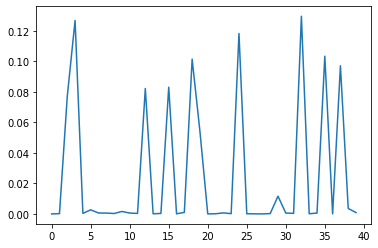

In [249]:
print(QMC_model.layers[8])
lamb = np.abs(QMC_model.layers[8].weights[2].numpy())
lamb = lamb / lamb.sum()
plt.plot(lamb)
num_comps = (lamb >= 0.01).sum()
print(f'Non-zero components:{num_comps}')

Now we train the model using label smoothing.

In [251]:
QMC_model = create_ViT_QMC_model(transformer_layers=1, gamma=gamma, n_comp=40, num_rff=512)
history = run_experiment(QMC_model, learning_rate=0.01, epochs=15, label_smoothing=0.4)

Epoch 1/15
211/211 [==============================] - 6s 17ms/step - loss: 1.7918 - accuracy: 0.7064 - val_loss: 1.5708 - val_accuracy: 0.9127
Epoch 2/15
211/211 [==============================] - 3s 15ms/step - loss: 1.5719 - accuracy: 0.9124 - val_loss: 1.5248 - val_accuracy: 0.9488
Epoch 3/15
211/211 [==============================] - 3s 15ms/step - loss: 1.5388 - accuracy: 0.9373 - val_loss: 1.5137 - val_accuracy: 0.9555
Epoch 4/15
211/211 [==============================] - 3s 15ms/step - loss: 1.5232 - accuracy: 0.9490 - val_loss: 1.5073 - val_accuracy: 0.9592
Epoch 5/15
211/211 [==============================] - 3s 15ms/step - loss: 1.5137 - accuracy: 0.9570 - val_loss: 1.4977 - val_accuracy: 0.9673
Epoch 6/15
211/211 [==============================] - 3s 15ms/step - loss: 1.5070 - accuracy: 0.9618 - val_loss: 1.4982 - val_accuracy: 0.9667
Epoch 7/15
211/211 [==============================] - 3s 15ms/step - loss: 1.5028 - accuracy: 0.9650 - val_loss: 1.4912 - val_accuracy: 0.9745

Non-zero components:25


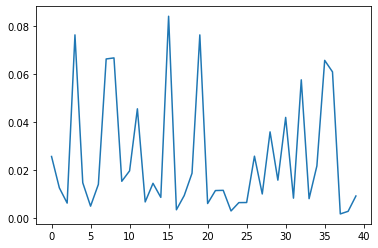

In [252]:
print(QMC_model.layers[8])
lamb = np.abs(QMC_model.layers[8].weights[2].numpy())
lamb = lamb / lamb.sum()
plt.plot(lamb)
num_comps = (lamb >= 0.01).sum()
print(f'Non-zero components:{num_comps}')

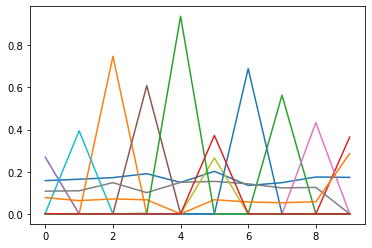

In [254]:
for i in range(len(lamb)):
  if lamb[i] >= 0.02:
    vals = QMC_model.layers[8].weights[1][:,i] 
    plt.plot(QMC_model.layers[8].weights[1][:,i]**2)

prediction:[[0.03567615 0.0555442  0.03151075 0.06076062 0.652371   0.03169453
  0.03257894 0.04056755 0.03336222 0.02593415]]


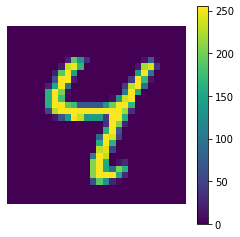

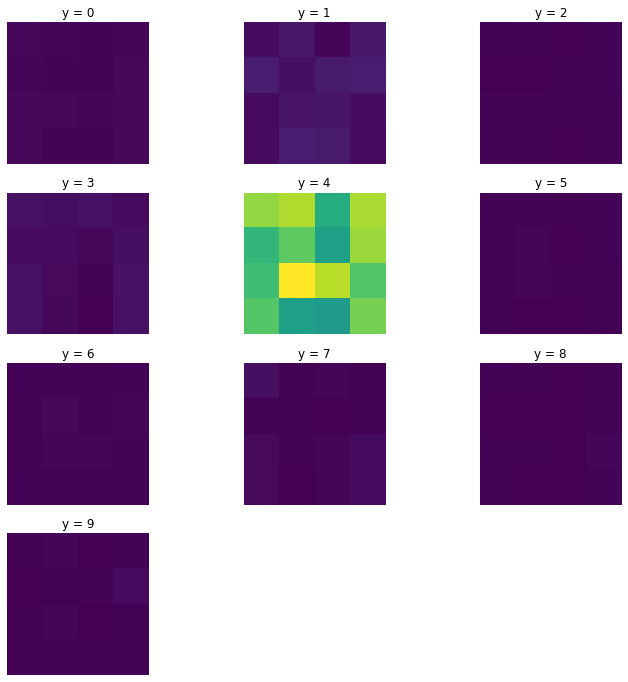

In [255]:
img_idx = 6
image_show(img_idx)
img_in = np.tile(x_test[img_idx], [10,1,1,1])
y_in = np.eye(10)
attention = attention_model(QMC_model, img_in, y_in)
attention_show(attention)
print(f'prediction:{QMC_model(x_test[img_idx:img_idx+1])}')

prediction:[[0.05018276 0.04698377 0.03985599 0.03514666 0.05681115 0.0506138
  0.04964525 0.09053002 0.03800201 0.54222864]]


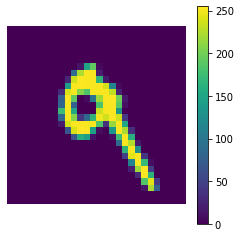

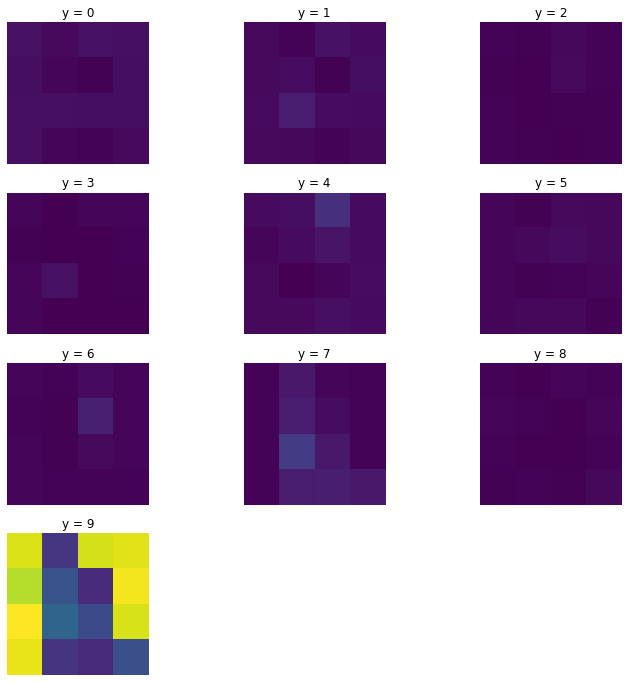

In [256]:
img_idx = 7
image_show(img_idx)
img_in = np.tile(x_test[img_idx], [10,1,1,1])
y_in = np.eye(10)
attention = attention_model(QMC_model, img_in, y_in)
attention_show(attention)
print(f'prediction:{QMC_model(x_test[img_idx:img_idx+1])}')